In [4]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
# Fix: DataLoader causing `RuntimeError: received 0 items of ancdata`
# set ulimit top higher, 
# !ulimit -n 4096 # no help, need to run outside and then start jupyter
# !ulimit -n
# 2048: e: 931 die
# torch.multiprocessing.set_sharing_strategy(

In [25]:
from chexnet import ChexNet
from unet import Unet
from dataset import ChestXray14Dataset
from transform import tta
from metrics import aucs
from constant import CLASS_NAMES, IMAGENET_MEAN, IMAGENET_STD
from fastai.conv_learner import *

from matplotlib.patches import Patch
import pandas as pd
import skimage
from scipy import ndimage
from pathlib import Path
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.utils.data import Dataset
import torch
import torchvision.transforms as transforms
from sklearn.metrics import roc_curve, auc

In [12]:
PATH = Path('/home/dattran/data/xray-thesis/chestX-ray14')
IMAGE_DN = 'images'
CSV_FILE = 'test.csv'

In [13]:
chexnet_model = '20180429-130928'
chexnet = ChexNet(trained=True, model_name=chexnet_model).cuda()
chexnet.eval();

In [14]:
normalize = transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
toTensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()

# Test one stage

In [15]:
def get_test_dl(sz, bs, tfm):
    df = pd.read_csv(PATH/CSV_FILE, header=None, sep=' ')
    image_names = df.iloc[:, 0].values
    labels = df.iloc[:, 1:].values
    dataset = ChestXray14Dataset(image_names, labels, tfm, PATH/IMAGE_DN, sz, percentage=1)
    return DataLoader(dataset, bs, num_workers=6)

In [40]:
def test(model, dl, tta=False):
    targets = []
    preds = []

    for image, target in dl:
        if tta:
            bs, cs, c, h, w = image.shape
            image = image.view(-1, c, h, w)
            
        pred = model(Variable(image.cuda()))
        if tta:
            pred = pred.view(bs, cs, -1).mean(1)
            
        targets.append(target.detach().cpu()) # detach remove this tensor from computation graph
        preds.append(pred.detach().cpu()) # if not call -> gpu memory leak since it still hold reference to computation graph

    targets = torch.cat(targets)
    preds = torch.cat(preds)

    all_aucs = aucs(torch.sigmoid(preds), targets)
    avg_auc = torch.mean(all_aucs)
    print(f'The average AUROC is {avg_auc:.3}')
    for i in range(14):
        print(f'The AUROC of {CLASS_NAMES[i]} is {all_aucs[i]:.3}')
    return targets, preds

## One crop

In [19]:
tfm = transforms.Compose([
    transforms.Resize(224),
    toTensor,
    normalize
])

In [23]:
dl = get_test_dl(224, 16, tfm)
test(chexnet, dl)

14
The average AUROC is 0.8393171429634094
The AUROC of Atelectasis is 0.8196786046028137
The AUROC of Cardiomegaly is 0.9163126945495605
The AUROC of Effusion is 0.8807909488677979
The AUROC of Infiltration is 0.7095602750778198
The AUROC of Mass is 0.8512624502182007
The AUROC of Nodule is 0.7740467190742493
The AUROC of Pneumonia is 0.7598370909690857
The AUROC of Pneumothorax is 0.8792376518249512
The AUROC of Consolidation is 0.8112032413482666
The AUROC of Edema is 0.8980737328529358
The AUROC of Emphysema is 0.9138238430023193
The AUROC of Fibrosis is 0.8202219605445862
The AUROC of Pleural Thickening is 0.7738888263702393
The AUROC of Hernia is 0.9425010681152344


(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[-4.1304,  0.0687, -4.9081,  ..., -6.7873, -6.2259, -6.7110],
         [-3.7361, -3.8990, -4.0629,  ..., -3.0944, -3.2320, -6.2526],
         [-4.2541, -5.3045, -5.7945,  ..., -5.0839, -4.5040, -6.4034],
         ...,
         [ 1.9721, -3.0610, -0.5468,  ..., -2.5845, -2.3203, -5.4191],
         [ 0.3750, -1.9573, -1.3323,  ..., -5.6233, -4.5870, -5.3308],
         [ 1.2997, -1.9967,  2.5815,  ..., -3.9492, -0.5702, -4.7518]]))

## Five Crop 

In [13]:
tfm = transforms.Compose([
    transforms.Resize(256),
    transforms.FiveCrop(224),
    transforms.Lambda(lambda crops: torch.stack([toTensor(crop) for crop in crops])),
    transforms.Lambda(lambda crops: torch.stack([normalize(crop) for crop in crops]))
])

In [14]:
dl = get_test_dl(224, 4, tfm)
test(chexnet, dl, tta=True)

14
The average AUROC is 0.8432148694992065
The AUROC of Atelectasis is 0.8277156949043274
The AUROC of Cardiomegaly is 0.9165109992027283
The AUROC of Effusion is 0.8823908567428589
The AUROC of Infiltration is 0.7107319831848145
The AUROC of Mass is 0.8593320250511169
The AUROC of Nodule is 0.7836706042289734
The AUROC of Pneumonia is 0.7619888782501221
The AUROC of Pneumothorax is 0.8812735080718994
The AUROC of Consolidation is 0.8143796324729919
The AUROC of Edema is 0.8990079760551453
The AUROC of Emphysema is 0.9198925495147705
The AUROC of Fibrosis is 0.8260948061943054
The AUROC of Pleural Thickening is 0.7786182165145874
The AUROC of Hernia is 0.9434009790420532


## Ten Crop

In [9]:
tfm = transforms.Compose([
    transforms.Resize(256),
    transforms.TenCrop(224),
    transforms.Lambda(lambda crops: torch.stack([toTensor(crop) for crop in crops])),
    transforms.Lambda(lambda crops: torch.stack([normalize(crop) for crop in crops]))
])

In [10]:
dl = get_test_dl(224, 2, tfm)
test(dl, tta=True)

14
The average AUROC is 0.844746470451355
The AUROC of Atelectasis is 0.828648030757904
The AUROC of Cardiomegaly is 0.9206342101097107
The AUROC of Effusion is 0.8830001354217529
The AUROC of Infiltration is 0.711686909198761
The AUROC of Mass is 0.8626240491867065
The AUROC of Nodule is 0.7845016121864319
The AUROC of Pneumonia is 0.7655033469200134
The AUROC of Pneumothorax is 0.8831501603126526
The AUROC of Consolidation is 0.8159202337265015
The AUROC of Edema is 0.8994050025939941
The AUROC of Emphysema is 0.9201325178146362
The AUROC of Fibrosis is 0.8274871706962585
The AUROC of Pleural Thickening is 0.7805037498474121
The AUROC of Hernia is 0.9432534575462341


# Segmentation

In [34]:
# Only for segmented case
class TestChestXray14Dataset(Dataset): 
    '''
    Get image for train, validate and test base on NIH split
    '''

    def __init__(self, image_names, labels, transform, path, size, percentage=0.1, segmented_dict=None):
        self.labels = labels
        self.percentage = percentage
        self.size = size
        self.image_names = image_names
        self.path = path
        self.transform = transform
        self.segmented_dict = segmented_dict
        
    def __getitem__(self, index):
        image_file = self.path/self.image_names[index]
        image = Image.open(image_file).convert('RGB') # 1 channel segmented_dictge
        coords = self.segmented_dict[self.image_names[index]].split(' ')
        bb = list(map(lambda x: int(x), coords))
        image = image.crop(bb)
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
        return image, torch.FloatTensor(label)

    def __len__(self):
        return int(self.image_names.shape[0] * self.percentage)

    @property
    def sz(self):
        # fastai compatible: learn.summary()
        return self.size

In [35]:
def get_segmented_test_dl(sz, bs, tfm, segmented_file):
    df = pd.read_csv(PATH/CSV_FILE, header=None, sep=' ')
    image_names = df.iloc[:, 0].values
    labels = df.iloc[:, 1:].values
    with open(PATH/segmented_file, 'rb') as f:
        d = pickle.load(f)
    dataset = TestChestXray14Dataset(image_names, labels, tfm, PATH/IMAGE_DN, sz, percentage=1, segmented_dict=d)
    return DataLoader(dataset, bs, num_workers=6)

In [41]:
def test_two_stage(dl, tta=False):
    targets = []
    preds = []

    for image, target in dl:
#         imgs = []
#         for img in image:
#             img = to_pil(img)
#             img_v = V(unet_tfm(img)[None])
#             py = torch.sigmoid(segmentor(V(img_v)))
#             py = (py[0].cpu() > 0.5).type(torch.FloatTensor)
#             labels = skimage.measure.label(py[0].numpy())
#             mask = np.logical_or(labels==2, labels==1).astype(np.float32) # left nd right lung, 0 for background
#             mask = cv2.resize(mask, (1024, 1024))
#             slice_y, slice_x = ndimage.find_objects(mask, 1)[0]
#             img = img.crop((slice_x.start, slice_y.start, slice_x.stop, slice_y.stop))
#             img = chexnet_tfm(img)
#             imgs.append(img)
#         imgs = torch.stack(imgs)

        if tta:
            bs, cs, c, h, w = image.shape
            image = image.view(-1, c, h, w)
            
        pred = chexnet(Variable(image.cuda()))
        
        if tta:
            pred = pred.view(bs, cs, -1).mean(1)
            
        targets.append(target.detach().cpu()) # detach remove this tensor from computation graph
        preds.append(pred.detach().cpu()) # if not call -> gpu memory leak since it still hold reference to computation graph

    targets = torch.cat(targets)
    preds = torch.cat(preds)

    all_aucs = aucs(torch.sigmoid(preds), targets)
    avg_auc = torch.mean(all_aucs)
    print(f'The average AUROC is {avg_auc:.3}')
    for i in range(14):
        print(f'The AUROC of {CLASS_NAMES[i]} is {all_aucs[i]:.3}')
    return targets, preds

In [18]:
chexnet_tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    toTensor,
    normalize
])
    
dl = get_segmented_test_dl(256, 16, chexnet_tfm, 'cut_all.pickle')
test_two_stage(dl, tta=False)

14
The average AUROC is 0.8434817790985107
The AUROC of Atelectasis is 0.8306014537811279
The AUROC of Cardiomegaly is 0.9176346063613892
The AUROC of Effusion is 0.8828996419906616
The AUROC of Infiltration is 0.7115110754966736
The AUROC of Mass is 0.8586274981498718
The AUROC of Nodule is 0.7888734340667725
The AUROC of Pneumonia is 0.764788806438446
The AUROC of Pneumothorax is 0.8801319599151611
The AUROC of Consolidation is 0.8131867051124573
The AUROC of Edema is 0.8989543318748474
The AUROC of Emphysema is 0.9113962650299072
The AUROC of Fibrosis is 0.8255955576896667
The AUROC of Pleural Thickening is 0.7815391421318054
The AUROC of Hernia is 0.9430039525032043


In [17]:
chexnet_tta_tfm = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.FiveCrop(224),
    transforms.Lambda(lambda crops: torch.stack([toTensor(crop) for crop in crops])),
    transforms.Lambda(lambda crops: torch.stack([normalize(crop) for crop in crops]))
])

dl = get_segmented_test_dl(256, 4, chexnet_tta_tfm, 'cut_all.pickle')
test_two_stage(dl, tta=True)

14
The average AUROC is 0.8412221074104309
The AUROC of Atelectasis is 0.8276405930519104
The AUROC of Cardiomegaly is 0.9151818156242371
The AUROC of Effusion is 0.877619206905365
The AUROC of Infiltration is 0.708827793598175
The AUROC of Mass is 0.8577368855476379
The AUROC of Nodule is 0.79429692029953
The AUROC of Pneumonia is 0.763827383518219
The AUROC of Pneumothorax is 0.877307653427124
The AUROC of Consolidation is 0.8115312457084656
The AUROC of Edema is 0.8934569954872131
The AUROC of Emphysema is 0.9035449624061584
The AUROC of Fibrosis is 0.8236665725708008
The AUROC of Pleural Thickening is 0.7734468579292297
The AUROC of Hernia is 0.9490238428115845


# ROC analysis

### 1 stage vs 2 stage

In [42]:
# 1 stage
dl = get_test_dl(224, 16, tfm)
one_stage_targets, one_stage_preds = test(chexnet, dl)
one_stage_roc = {}
for i in range(len(CLASS_NAMES)):
    one_stage_roc[CLASS_NAMES[i]] = roc_curve(to_np(one_stage_targets[:, i]), to_np(one_stage_preds[:, i]))

14
The average AUROC is 0.839
The AUROC of Atelectasis is 0.82
The AUROC of Cardiomegaly is 0.916
The AUROC of Effusion is 0.881
The AUROC of Infiltration is 0.71
The AUROC of Mass is 0.851
The AUROC of Nodule is 0.774
The AUROC of Pneumonia is 0.76
The AUROC of Pneumothorax is 0.879
The AUROC of Consolidation is 0.811
The AUROC of Edema is 0.898
The AUROC of Emphysema is 0.914
The AUROC of Fibrosis is 0.82
The AUROC of Pleural Thickening is 0.774
The AUROC of Hernia is 0.943


In [43]:
# 2 stage
chexnet_tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    toTensor,
    normalize
])
    
dl = get_segmented_test_dl(256, 16, chexnet_tfm, 'cut_all.pickle')
two_stage_targets, two_stage_preds = test_two_stage(dl, tta=False)
two_stage_roc = {}
for i in range(len(CLASS_NAMES)):
    two_stage_roc[CLASS_NAMES[i]] = roc_curve(to_np(two_stage_targets[:, i]), to_np(two_stage_preds[:, i]))

14
The average AUROC is 0.843
The AUROC of Atelectasis is 0.831
The AUROC of Cardiomegaly is 0.918
The AUROC of Effusion is 0.883
The AUROC of Infiltration is 0.712
The AUROC of Mass is 0.859
The AUROC of Nodule is 0.789
The AUROC of Pneumonia is 0.765
The AUROC of Pneumothorax is 0.88
The AUROC of Consolidation is 0.813
The AUROC of Edema is 0.899
The AUROC of Emphysema is 0.911
The AUROC of Fibrosis is 0.826
The AUROC of Pleural Thickening is 0.782
The AUROC of Hernia is 0.943


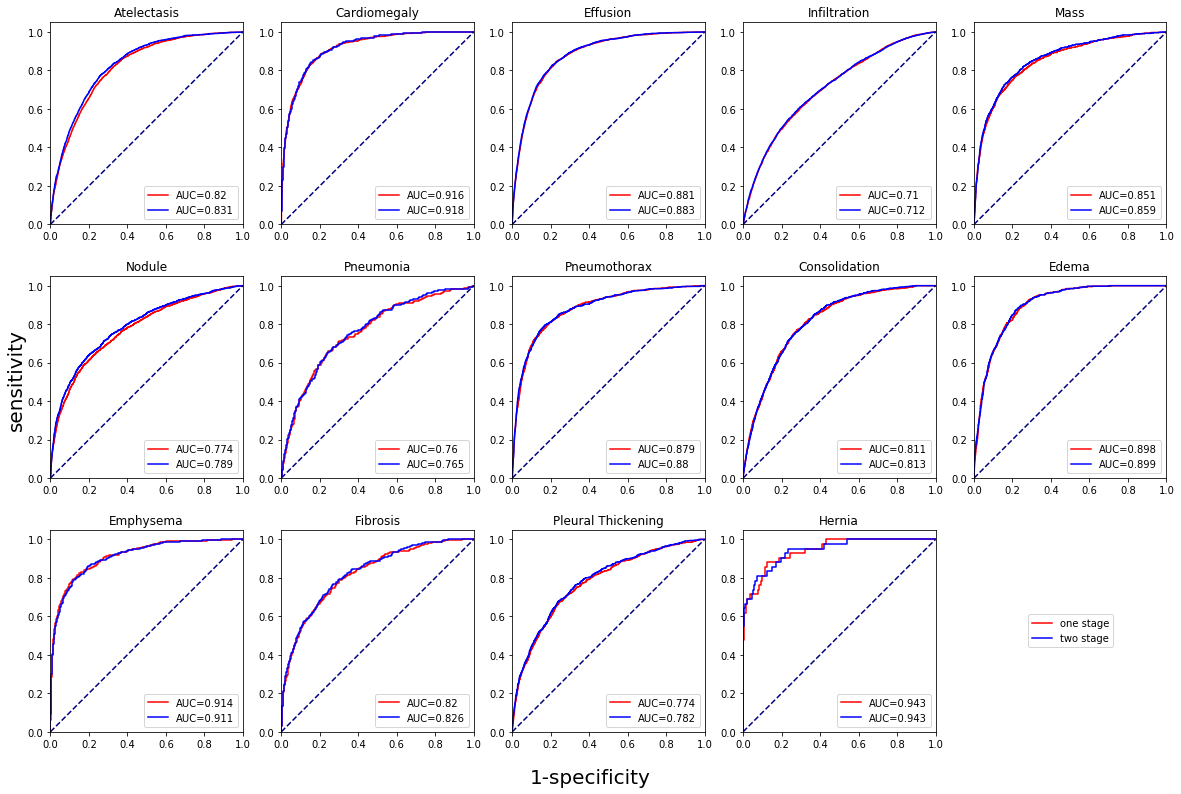

In [39]:
fig, axes = plt.subplots(3, 5, figsize=(20, 14))
for i, ax in enumerate(axes.flat):
    if i == 14:
        ax.plot(0, 0, c='r', label='one stage')
        ax.plot(0, 0, c='b', label='two stage')
        ax.legend( loc='center')
        ax.set_axis_off()
        break
    cn = CLASS_NAMES[i]
    
    # one stage
    fpr, tpr, threshold = one_stage_roc[cn]
    one_stage_auc = auc(fpr, tpr)
    one_stage_artist = ax.plot(fpr, tpr , c='r', label=f'AUC={one_stage_auc:0.3}')
    
    # two stage
    fpr, tpr, threshold = two_stage_roc[cn]
    two_stage_auc = auc(fpr, tpr)
    two_stage_artist = ax.plot(fpr, tpr, c='b', label=f'AUC={two_stage_auc:.3}')
    
    # enhance
    ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_aspect('equal', 'box')
    ax.set_title(cn)
    ax.legend(loc='lower right')

fig.text(0.5, 0.1, '1-specificity', ha='center', fontsize=20)
fig.text(0.095, 0.5, 'sensitivity', va='center', rotation='vertical', fontsize=20)

plt.subplots_adjust(hspace=0.0001)
fig.savefig('two_stage_roc.png')

### resnet vs densenet

In [44]:
from models.resnet import Resnet

MODEL_FILE = '/mnt/data/xray-thesis/models/resnet/resnet50/20180501-212649/model.path.tar'
d = torch.load(MODEL_FILE)
model_state = d['state_dict']

In [45]:
resnet = Resnet('resnet50').cuda()
resnet.load_state_dict(model_state)

In [46]:
dl = get_test_dl(224, 16, tfm)

In [47]:
# resnet
resnet_targets, resnet_preds = test(resnet, dl)
resnet_roc = {}
for i in range(len(CLASS_NAMES)):
    resnet_roc[CLASS_NAMES[i]] = roc_curve(to_np(resnet_targets[:, i]), to_np(resnet_preds[:, i]))

14
The average AUROC is 0.754
The AUROC of Atelectasis is 0.754
The AUROC of Cardiomegaly is 0.785
The AUROC of Effusion is 0.806
The AUROC of Infiltration is 0.642
The AUROC of Mass is 0.749
The AUROC of Nodule is 0.684
The AUROC of Pneumonia is 0.704
The AUROC of Pneumothorax is 0.724
The AUROC of Consolidation is 0.726
The AUROC of Edema is 0.828
The AUROC of Emphysema is 0.798
The AUROC of Fibrosis is 0.766
The AUROC of Pleural Thickening is 0.701
The AUROC of Hernia is 0.884


In [48]:
# densnet
densenet_targets, densenet_preds = test(chexnet, dl)
densenet_roc = {}
for i in range(len(CLASS_NAMES)):
    densenet_roc[CLASS_NAMES[i]] = roc_curve(to_np(densenet_targets[:, i]), to_np(densenet_preds[:, i]))

14
The average AUROC is 0.839
The AUROC of Atelectasis is 0.82
The AUROC of Cardiomegaly is 0.916
The AUROC of Effusion is 0.881
The AUROC of Infiltration is 0.71
The AUROC of Mass is 0.851
The AUROC of Nodule is 0.774
The AUROC of Pneumonia is 0.76
The AUROC of Pneumothorax is 0.879
The AUROC of Consolidation is 0.811
The AUROC of Edema is 0.898
The AUROC of Emphysema is 0.914
The AUROC of Fibrosis is 0.82
The AUROC of Pleural Thickening is 0.774
The AUROC of Hernia is 0.943


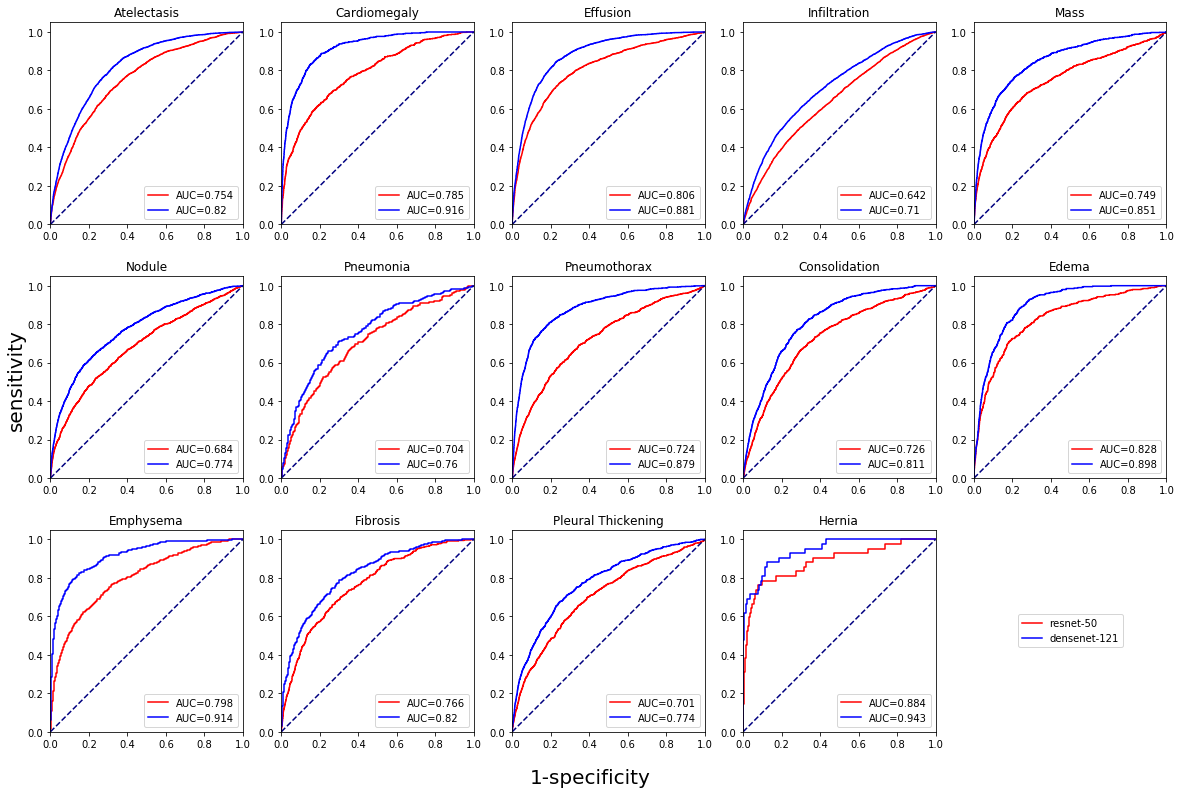

In [30]:
fig, axes = plt.subplots(3, 5, figsize=(20, 14))
for i, ax in enumerate(axes.flat):
    if i == 14:
        ax.plot(0, 0, c='r', label='resnet-50')
        ax.plot(0, 0, c='b', label='densenet-121')
        ax.legend( loc='center')
        ax.set_axis_off()
        break
    cn = CLASS_NAMES[i]
    
    # resnet
    fpr, tpr, threshold = resnet_roc[cn]
    resnet_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr , c='r', label=f'AUC={resnet_auc:.3}')
    
    # densenet
    fpr, tpr, threshold = densenet_roc[cn]
    densenet_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, c='b', label=f'AUC={densenet_auc:.3}')
    
    # enhance
    ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_aspect('equal', 'box')
    ax.set_title(cn)
    ax.legend(loc='lower right')

fig.text(0.5, 0.1, '1-specificity', ha='center', fontsize=20)
fig.text(0.095, 0.5, 'sensitivity', va='center', rotation='vertical', fontsize=20)

plt.subplots_adjust(hspace=0.0001)
fig.savefig('res_dense_roc.png')